# <center>Nuts and Bolts of Convolution Neural Networks</center>
<center>
        "Shan-Hung Wu & DataLab"
        <br>
        "Fall 2018"
</center>

In this lab, we introduce two datasets, **mnist** and **cifar**, then we will talk about how to implement CNN models for these two datasets using tensorflow. The major difference between mnist and cifar is their size. Due to the limit of memory size and time issue, we offer a guide to illustrate typical **input pipeline** of tensorflow. Let's dive into tensorflow!

## MNIST Dataset

We start from a simple dataset. MNIST is a simple computer vision dataset. It consists of images of handwritten digits like:

<center><img style='width: 30%' src='imgsrc/MNIST.png' /></center>

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1. Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

<center><img style='width: 30%' src='imgsrc/MNIST2.png' /></center>

The MNIST data is hosted on [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). We can directly import MNIST dataset from Tensorflow. 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import os

dest_directory = 'dataset/mnist'
# check the directory
if not os.path.exists(dest_directory):
  os.makedirs(dest_directory)
# import data
mnist = input_data.read_data_sets("dataset/mnist/", one_hot=True)

/home/hcgogogo/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting dataset/mnist/train-images-idx3-ubyte.gz
Extracting dataset/mnist/train-labels-idx1-ubyte.gz
Extracting dataset/mnist/t10k-images-idx3-ubyte.gz
Extracting dataset/mnist/t10k-labels-idx1-ubyte.gz


### Softmax Regression on MNIST

Before jumping to *Convolutional Neural Network* model, we're going to start with a very simple model with a single layer and softmax regression.

We know that every image in MNIST is a handwritten digit between zero and nine. So there are only ten possible digits that a given image can be. We want to give the probability of the input image for being each digit. That is, input an image, the model outputs a ten-dimension vector.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do.

In [3]:
def fully_connected_layer(x_inputs, out_dim, name='fc'):
  """ 
      x_inputs: a batch examples [batch_size, feature_dims]
      out_dim: neurons in this layer.
  """ 
  in_dim = x_inputs.shape[-1] # feature_dims
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
      weights = tf.get_variable("weights", shape=[in_dim, out_dim])
      bias = tf.get_variable("bias", shape=[out_dim])
      out = tf.matmul(x_inputs, weights) + bias
      return out

In [4]:
class MNIST_model_fully(object):
  def __init__(self, dataset, hps):
    self.dataset = dataset
    #setting hyperparameters
    self.training_steps = hps.steps
    self.batch_size = hps.steps
    self.input_dim = hps.input_dim
    self.output_dim = hps.output_dim
    #define weights and build model architecture
    self._build_model()
    
  def _build_model(self):
    with tf.name_scope("input") as scope:
      self.x = tf.placeholder(tf.float32,[None, self.input_dim])  # flatten into vector of 28 x 28 = 784
      self.y_true = tf.placeholder(tf.float32, [None, self.output_dim])  # true answers

    with tf.name_scope("network") as scope:
      self.y_pred = fully_connected_layer(self.x, self.output_dim, name='out')

    with tf.name_scope("loss_func") as scope:
      self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_true, 
                                                                                  logits=self.y_pred))
      correct_prediction = tf.equal(tf.argmax(self.y_pred, 1), tf.argmax(self.y_true, 1))
      self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.name_scope("train_op") as scope:
      self.train_op = tf.train.GradientDescentOptimizer(0.5).minimize(self.cross_entropy)  
      
  def train(self):
    for step in range(self.training_steps):
      batch_x, batch_y = self.dataset.train.next_batch(self.batch_size)
      self.sess.run(self.train_op, feed_dict = {
          self.x: batch_x,
          self.y_true: batch_y
        })
  def test(self):
    test_x, test_y = self.dataset.test.images, self.dataset.test.labels
    test_accuracy = self.sess.run(self.accuracy, feed_dict = {
          self.x: test_x, 
          self.y_true: test_y
      })
    print("Testing Accuracy : %.3f" %test_accuracy)
  def run(self):
    #define session and initialize variables
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())
    self.train()
    self.test()
    self.sess.close()

Using ```tf.contib.training.HParams``` can help you control your hyperparameters.

In [5]:
model_hps= tf.contrib.training.HParams(
  steps = 1000, 
  batch_size = 32,
  input_dim = 784,
  output_dim = 10
)

After creating our model and defining the loss and optimizer, we can start training.

In [6]:
mnist_fc_model = MNIST_model_fully(mnist, model_hps)
mnist_fc_model.run()

Testing Accuracy : 0.921


From the above result, we got about 92% accuracy for *Softmax Regression* on MNIST. In fact, it's not so good. This is because we're using a very simple model.

### Multilayer Convolutional Network on MNIST

We're now jumping from a very simple model to something moderately sophisticated: a small *Convolutional Neural Network*. This will get us to around 99.2% accuracy, not state of the art, but respectable.

Here is the diagram of the model we're going to build:

<center><img style='width: 30%' src='imgsrc/mnist_deep.png' /></center>

TensorFlow gives us a lot of flexibility in **convolution** and **pooling** operations. How do we handle the boundaries? What is our stride size? For now, we're going to choose the vanilla version. To keep our code cleaner, let's also abstract those operations into functions.

In [7]:
# Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input.
# Our pooling is plain old max pooling over 2x2 blocks.
def conv_block(x, name, kernel_width, kernel_height, inp_channel, out_channel, strides = [1, 1, 1, 1], padding='SAME'):
  W_conv = tf.get_variable(name+'w', [kernel_width, kernel_height, inp_channel, out_channel])
  b_conv = tf.get_variable(name+'b', [out_channel])
  return tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=strides, padding=padding)+b_conv)

def max_pool_2x2(x):
  return tf.nn.max_pool(
      x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

We can now implement our model.

In [8]:
class MNIST_model_cnn(object):
  def __init__(self, dataset, hps):
    self.dataset = dataset
    #setting hyperparameters
    self.training_steps = hps.steps
    self.batch_size = hps.steps
    self.image_size = hps.image_size
    self.output_dim = hps.output_dim
    self.dropout_keep_prob = hps.dropout_keep_prob
    #define weights and build model architecture
    self._build_model()
    
  def _build_model(self):
    with tf.name_scope("input") as scope:
      self.x = tf.placeholder(tf.float32,[None, self.image_size*self.image_size*1])  # flatten into vector of 28 x 28 = 784
      self.y_true = tf.placeholder(tf.float32, [None, self.output_dim])  # true answers

    with tf.name_scope("network") as scope:
      # self.y_pred = fully_connected_layer(self.x, self.output_dim, name='out')
      x_image = tf.reshape(self.x, [-1, self.image_size, self.image_size, 1])
      # 1st convolutional layer
      # cnn kernel : [5, 5, 1] *32, output shape = [batch, 28, 28, 32]
      h_conv1 = conv_block(x_image, "conv1", 5, 5, 1, 32)
      # 2x2 pooling, output shape = [batch, 14, 14, 32]
      h_pool1 = max_pool_2x2(h_conv1)
      
      # 2nd convolutional layer
      h_conv2 = conv_block(h_pool1, "conv2", 5, 5, 32, 64)
      # 2x2 pooling, output shape = [batch, 7, 7, 64]
      h_pool2 = max_pool_2x2(h_conv2)
      
      # Densely connected layer
      # Flatten the feature maps into [batch, 7 x 7 x 64]
      h_pool2_flat = tf.reshape(h_pool2, [-1, self.image_size//4 * self.image_size//4 * 64]) 
      
      # We add a fully-connected layer with 1024 neurons to allow processing on the entire image.
      h_fc1 = tf.nn.relu(fully_connected_layer(h_pool2_flat, 1024, name='fc1'))
      
      # Dropout, this can prevent overfitting
      self.keep_prob = tf.placeholder(tf.float32)
      h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)
      
      # Finally, we add the output layer, just like for the one layer softmax regression above.
      self.y_pred = fully_connected_layer(h_fc1_drop, self.output_dim, name='out')
      
    # After defining our model, we then define our loss and optimizer.
    with tf.name_scope("loss_func") as scope:
      self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_true, 
                                                                                  logits=self.y_pred))
      correct_prediction = tf.equal(tf.argmax(self.y_pred, 1), tf.argmax(self.y_true, 1))
      self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.name_scope("train_op") as scope:
      self.train_op = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
      
  def train(self):
    for step in range(self.training_steps):
      batch_x, batch_y = self.dataset.train.next_batch(self.batch_size)
      _, accuracy = self.sess.run((self.train_op, self.accuracy), feed_dict = {
          self.x: batch_x,
          self.y_true: batch_y,
          self.keep_prob: self.dropout_keep_prob
        })
      if step % 200 == 0:
        print("Step %d, Training Accuracy: %.3f" %(step, accuracy))
        
    print("Step %d, Training Accuracy: %.3f" %(step, accuracy))
        
  def test(self):
    test_x, test_y = self.dataset.test.images, self.dataset.test.labels
    test_accuracy = self.sess.run(self.accuracy, feed_dict = {
          self.x: test_x, 
          self.y_true: test_y, 
          self.keep_prob: 1.0 #when testing, we don't apply dropout
      })
    print("Testing Accuracy : %.3f" %test_accuracy)
  def run(self):
    #define session and initialize variables
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())
    self.train()
    self.test()
    self.sess.close()

To reduce overfitting, we will apply [*dropout*](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) before the readout layer. The idea behind dropout is to train an ensemble of model instead of a single model. During training, we drop out neurons with probability $p$, i.e., the probability to keep is $1-p$. When a neuron is dropped, its output is set to zero. These dropped neurons do not contribute to the training phase in forward pass and backward pass. For each training phase, we train the network slightly different from the previous one. It's just like we train different networks in each training phrase. However, during testing phase, we **don't** drop any neuron, and thus, implement dropout is kind of like doing ensemble. Also, randomly drop units in training phase can prevent units from co-adapting too much. Thus, dropout is a powerful regularization techique to deal with *overfitting*. 
 
We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing.

Let's check how well does this model do! Note that we will include the additional parameter **keep_prob** in feed_dict to control the dropout rate.

In [9]:
model_hps_cnn = tf.contrib.training.HParams(
  steps = 2000, 
  batch_size = 32,
  image_size = 28,
  output_dim = 10,
  dropout_keep_prob = 0.5
)

In [10]:
tf.reset_default_graph()
CNN_model = MNIST_model_cnn(mnist, model_hps_cnn)

In [11]:
CNN_model.run()

Step 0, Training Accuracy: 0.113
Step 200, Training Accuracy: 0.929
Step 400, Training Accuracy: 0.974
Step 600, Training Accuracy: 0.982
Step 800, Training Accuracy: 0.986
Step 1000, Training Accuracy: 0.989
Step 1200, Training Accuracy: 0.990
Step 1400, Training Accuracy: 0.993
Step 1600, Training Accuracy: 0.993
Step 1800, Training Accuracy: 0.992
Step 1999, Training Accuracy: 0.993
Testing Accuracy : 0.991


The final testing accuracy should be approximately 99%

## Cifar-10

Actually MNIST is a easy dataset for the beginner. To demonstrate the power of *Neural Networks*, we need a larger dataset *CIFAR-10*.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Here are the classes in the dataset, as well as 10 random images from each:

<center><img style='width: 40%' src='imgsrc/CIFAR10.png' /></center>

Before jumping to a complicated neural network model, we're going to start with **KNN** and **SVM**. The motivation here is to compare neural network model with traditional classifiers, and highlight the performance of neural network model.  

Keras offers convenient facilities that automatically download some well-known datasets and store them in the ~/.keras/datasets directory. Let's load the CIFAR-10 in Keras:

In [13]:
# Loading Data
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np
import math

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# convert class vectors to binary vectors
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 97s 1us/step
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


The data are loaded as integers, so we need to cast it to floating point values in order to perform the division:

In [14]:
# Data Preprocessing
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

For simplicity, we also convert the images into the grayscale. We use the [Luma coding](https://en.wikipedia.org/wiki/Grayscale#Luma_coding_in_video_systems) that is common in video systems:

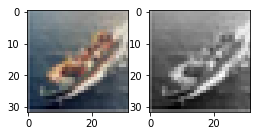

In [15]:
import matplotlib.pyplot as plt
# transform an 3-channel image into one channel
def grayscale(data, dtype='float32'):
  # luma coding weighted average in video systems
  r = np.asarray(.3, dtype=dtype)
  g = np.asarray(.59, dtype=dtype)
  b = np.asarray(.11, dtype=dtype)
  rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
  # add channel dimension
  rst = np.expand_dims(rst, axis=3)
  return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# plot a randomly chosen image
img = round(np.random.rand() * X_train.shape[0])
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(
    X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

As we can see, the objects in grayscale images can still be recognizable.

#### Feature Selection
When coming to object detection, HOG (histogram of oriented gradients) is often extracted as a feature for classification. It first calculates the gradients of each image patch using sobel filter, then use the magnitudes and orientations of derived gradients to form a histogram per patch (a vector). After normalizing these histograms, it concatenates them into one HOG feature. For more details, read this [tutorial](https://www.learnopencv.com/histogram-of-oriented-gradients/). 
>Note.  one can directly feed the original images for classification; however, it will take lots of time to train and get worse performance.

In [16]:
# The code is credit to: "http://www.itdadao.com/articles/c15a1243072p0.html"
def getHOGfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
  cx, cy = pixels_per_cell
  bx, by = cells_per_block
  sx, sy, sz = image.shape
  n_cellsx = int(np.floor(sx // cx))  # number of cells in x
  n_cellsy = int(np.floor(sy // cy))  # number of cells in y
  n_blocksx = (n_cellsx - bx) + 1
  n_blocksy = (n_cellsy - by) + 1
  gx = np.zeros((sx, sy), dtype=np.double)
  gy = np.zeros((sx, sy), dtype=np.double)
  eps = 1e-5
  grad = np.zeros((sx, sy, 2), dtype=np.double)
  for i in range(1, sx - 1):
    for j in range(1, sy - 1):
      gx[i, j] = image[i, j - 1] - image[i, j + 1]
      gy[i, j] = image[i + 1, j] - image[i - 1, j]
      grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
      if gx[i, j] < 0:
        grad[i, j, 0] += 180
      grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
      grad[i, j, 1] = np.sqrt(gy[i, j]**2 + gx[i, j]**2)
  normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
  for y in range(n_blocksy):
    for x in range(n_blocksx):
      block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
      hist_block = np.zeros(32, dtype=np.double)
      eps = 1e-5
      for k in range(by):
        for m in range(bx):
          cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
          hist_cell = np.zeros(8, dtype=np.double)
          for i in range(cy):
            for j in range(cx):
              n = int(cell[i, j, 0] / 45)
              hist_cell[n] += cell[i, j, 1]
          hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
      normalised_blocks[y, x, :] = hist_block / np.sqrt(
          hist_block.sum()**2 + eps)
  return normalised_blocks.ravel()

Once we have our *getHOGfeat* function, we then get the HOG features of all images.

In [17]:
X_train_hog = []
X_test_hog = []

print('This will take some minutes.')

for img in X_train_gray:
  img_hog = getHOGfeat(img)
  X_train_hog.append(img_hog)

for img in X_test_gray:
  img_hog = getHOGfeat(img)
  X_test_hog.append(img_hog)

X_train_hog_array = np.asarray(X_train_hog)
X_test_hog_array = np.asarray(X_test_hog)

This will take some minutes.


### K Nearest Neighbors (KNN) on CIFAR-10

[scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) provides off-the-shelf libraries for classification. For KNN and SVM classifiers, we can just import from scikit-learn to use.

In [18]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_hog_array, y_train.ravel())
y_pred = knn.predict(X_test_hog_array)
print('[KNN]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[KNN]
Misclassified samples: 5334
Accuracy: 0.47


We can observe that the accuracy of KNN on CIFAR-10 is embarrassingly bad.

### Support Vector Machine (SVM) on CIFAR-10

In [19]:
# SVM
from sklearn.svm import SVC 

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_linear = SVC(kernel='linear', random_state=0, gamma=0.2, C=10.0)

svm_linear.fit(X_train_hog_array, y_train.ravel())
y_pred = svm_linear.predict(X_test_hog_array)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test.ravel(), y_pred))

[Linear SVC]
Misclassified samples: 4940
Accuracy: 0.51


By above, SVM is slightly better than KNN, but still poor. Next, we'll design a CNN model using tensorflow. Because the cifar10 is not a small dataset, we can't just use feed_dict to feed all training data to the model due to the limit of memory size. Even if we can feed all data into the model, we still want the process of loading data is efficient. **Input pipeline** is the common way to solve these.

## Input Pipeline

### Queues
Because tf.Session objects are designed to be **multithreaded** and thread-safe, so multiple threads can easily use the same session and run ops in parallel. [Queues](https://www.tensorflow.org/programmers_guide/threading_and_queues) are useful because of the ability to **compute tensor asynchronously** in a graph. Most of the time, we use queues to handle inputs. In this way, multiple threads prepare training example and enequeue these examples. In addition, only parts of inputs would be read into memory a time, instead of all of them. This can avoid **out of memory error** when data is large.


### Typical Input Pipeline
1. The list of filenames
2. Optional filename shuffling
3. Optional epoch limit
4. Filename queue
5. A Reader for the file format
6. A decoder for a record read by the reader
7. Optional preprocessing
8. Example queue  

<center><img style='width: 70%' src='imgsrc/AnimatedFileQueues.gif' /></center>  

We've specified the order of input pipeline in the followng codes.

In [20]:
import os
import sys
from six.moves import urllib
import tarfile
import tensorflow as tf
import numpy as np

#### Loading Data Manually
To know how it works under the hood, let's load CIFAR-10 by our own (not using keras). According the descripion, the dataset file is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. We define some constants based on the above:

In [21]:
# the url to download CIFAR-10 dataset (binary version)
# see format and details here: http://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
DEST_DIRECTORY = 'dataset/cifar10'
# the image size we want to keep
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3
IMAGE_SIZE_CROPPED = 24
BATCH_SIZE = 128
# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10 
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

In [22]:
def maybe_download_and_extract(dest_directory, url):
  """
    Download the dataset and extract the data
  """
    
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  file_name = 'cifar-10-binary.tar.gz'
  file_path = os.path.join(dest_directory, file_name)
  # if have not downloaded yet
  if not os.path.exists(file_path):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r%.1f%%' % 
            (float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()  # flush the buffer

    print('>> Downloading %s ...' % file_name)
    file_path, _ = urllib.request.urlretrieve(url, file_path, _progress)
    file_size = os.stat(file_path).st_size
    print('\r>> Total %d bytes' % file_size)
  extracted_dir_path = os.path.join(dest_directory, 'cifar-10-batches-bin')
  if not os.path.exists(extracted_dir_path):
    # Open for reading with gzip compression, then extract all
    tarfile.open(file_path, 'r:gz').extractall(dest_directory)
  print('>> Done')

# download it
maybe_download_and_extract(DEST_DIRECTORY, DATA_URL)

>> Done


After downloading the dataset, we create functions
* ```distort_input(training_file, batch_size)``` to get a training example queue.
* ```eval_input(testing_file, batch_size)``` to get a testing example queue.
* ```read_cifar10(filename_queue)``` to read a record from dataset with a filename queue. 

In [23]:
# the folder store the dataset
DATA_DIRECTORY = DEST_DIRECTORY + '/cifar-10-batches-bin'
# (1) a list of training/testing filenames
training_files = [os.path.join(DATA_DIRECTORY, 'data_batch_%d.bin' % i) for i in range(1,6)]
testing_files = [os.path.join(DATA_DIRECTORY, 'test_batch.bin')]

In [24]:
# (5) + (6)
def read_cifar10(filename_queue):
  """ Reads and parses examples from CIFAR10 data files.
    -----
    Args:
        filename_queue: 
            A queue of strings with the filenames to read from.
    Returns:
        An object representing a single example, with the following fields:
        height: 
            number of rows in the result (32)
        width: 
            number of columns in the result (32)
        depth: 
            number of color channels in the result (3)
        key: 
            a scalar string Tensor describing the filename & record number for this example.
        label: 
            an int32 Tensor with the label in the range 0..9.
        image: 
            a [height, width, depth] uint8 Tensor with the image data
  """

  class CIFAR10Record(object):
    pass

  result = CIFAR10Record()
  # CIFAR10 consists of 60000 32x32 'color' images in 10 classes
  label_bytes = 1  # 10 class
  result.height = IMAGE_HEIGHT
  result.width = IMAGE_WIDTH
  result.depth = IMAGE_DEPTH
  image_bytes = result.height * result.width * result.depth
  # bytes of a record: label(1 byte) followed by pixels(3072 bytes)
  record_bytes = label_bytes + image_bytes
  # (5) reader for cifar10 file format
  reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
  # read a record
  result.key, record_string = reader.read(filename_queue)
  # Convert from a string to a vector of uint8 that is record_bytes long.
  # (6) decoder
  record_uint8 = tf.decode_raw(record_string, tf.uint8)
  # get the label and cast it to int32
  result.label = tf.cast(
      tf.strided_slice(record_uint8, [0], [label_bytes]), tf.int32)
  # [depth, height, width], uint8
  depth_major = tf.reshape(
      tf.strided_slice(record_uint8, [label_bytes],
                       [label_bytes + image_bytes]),
      [result.depth, result.height, result.width])
  # change to [height, width, depth], uint8
  result.image = tf.transpose(depth_major, [1, 2, 0])
  return result

In [25]:
def distort_input(training_files, batch_size):
  """ Construct distorted input for CIFAR training using the Reader ops.
    -----
    Args:
        training_files: 
            an array of paths of the training files.
        batch_size: 
            Number of images per batch.
    Returns:
        images: Images. 
            4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
        labels: Labels. 
            1D tensor of [batch_size] size.
  """
  for f in training_files:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)
  # create a queue that produces filenames to read
  # (4) filename queue
  file_queue = tf.train.string_input_producer(training_files)
  # (5) + (6)
  cifar10_record = read_cifar10(file_queue)
  # (7) image preprocessing for training
  height = IMAGE_SIZE_CROPPED
  width = IMAGE_SIZE_CROPPED
  float_image = tf.cast(cifar10_record.image, tf.float32)
  distorted_image = tf.random_crop(float_image, [height, width, 3])
  distorted_image = tf.image.random_flip_left_right(distorted_image)
  distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
  distorted_image = tf.image.random_contrast(
      distorted_image, lower=0.2, upper=1.8)
  # standardization: subtract off the mean and divide by the variance of the pixels
  distorted_image = tf.image.per_image_standardization(distorted_image)
  # Set the shapes of tensors.
  distorted_image.set_shape([height, width, 3])
  cifar10_record.label.set_shape([1])
  # ensure a level of mixing of elements.
  min_fraction_of_examples_in_queue = 0.4
  min_queue_examples = int(
      NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * min_fraction_of_examples_in_queue)
  # (8) example queue
  # Filling queue with min_queue_examples CIFAR images before starting to train
  image_batch, label_batch = tf.train.shuffle_batch(
      [distorted_image, cifar10_record.label],
      batch_size=batch_size,
      num_threads=16,
      capacity=min_queue_examples + 3 * batch_size,
      min_after_dequeue=min_queue_examples)
  return image_batch, tf.reshape(label_batch, [batch_size])

The following code is to generate the data for testing. Now, you are able to specify the order of input pipeline in the following code block.

In [26]:
def eval_input(testing_files, batch_size):
  for f in testing_files:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)
  # create a queue that produces filenames to read
  file_queue = tf.train.string_input_producer(testing_files)
  cifar10_record = read_cifar10(file_queue)
  # image preprocessing for training
  height = IMAGE_SIZE_CROPPED
  width = IMAGE_SIZE_CROPPED
  float_image = tf.cast(cifar10_record.image, tf.float32)
  resized_image = tf.image.resize_image_with_crop_or_pad(
      float_image, height, width)
  image_eval = tf.image.per_image_standardization(resized_image)
  image_eval.set_shape([height, width, 3])
  cifar10_record.label.set_shape([1])
  # Ensure that the random shuffling has good mixing properties.
  min_fraction_of_examples_in_queue = 0.4
  min_queue_examples = int(
      NUM_EXAMPLES_PER_EPOCH_FOR_EVAL * min_fraction_of_examples_in_queue)
  image_batch, label_batch = tf.train.batch(
      [image_eval, cifar10_record.label],
      batch_size=batch_size,
      num_threads=16,
      capacity=min_queue_examples + 3 * batch_size)
  return image_batch, tf.reshape(label_batch, [batch_size])

After building the input pipeline, we can check the functionality of the example queues.

In [27]:
# test function distort_input
with tf.Session() as sess:
  coord = tf.train.Coordinator()
  image, label = distort_input(training_files, BATCH_SIZE)
  # --- Note ---
  # If you forget to call start_queue_runners(), it will hang
  # indefinitely and deadlock the user program.
  # ------------
  threads = tf.train.start_queue_runners(sess=sess, coord=coord)
  image_batch, label_batch = sess.run([image, label])
  coord.request_stop()
  coord.join(threads)
  image_batch_np = np.asarray(image_batch)
  label_batch_np = np.asarray(label_batch)
  print('Shape of cropped image:', image.shape)
  print('Shape of label:', label.shape)

Shape of cropped image: (128, 24, 24, 3)
Shape of label: (128,)


So far, we have prepared input queues. Let's start designing our cnn model!

###  Tensorflow Dataset API

From last lab, we briefly introduced `tf.data.Dataset` API for reading data.

> Tensorflow recommended queue-base input pipeline before version 1.2. After with version 1.2, tensorflow recommend using the [tf.data](https://www.tensorflow.org/programmers_guide/datasets) instead. Read [more](https://github.com/tensorflow/tensorflow/issues/7951).

To build a data input pipeline with `tf.data.Dataset`, here are the steps for you can follow:
1. Define data source and initialize your Dataset object
2. Apply transformations on the dataset, following are some common useful techniques
    - map
    - batch
    - shuffle
    - repeat
3. Create iterator 


#### Construct your Dataset 
First, we have to construct a Dataset object from our data source(some tensors in the memory, or data stored in the disk such as [TFRecord](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset) format)

Now suppose we have simple data sources:

In [28]:
# an array with shape (8, 5)
raw_data_a = np.array([[1, 1.1, 1.2, 1.3, 1.4], 
                     [2, 2.1, 2.2, 2.3, 2.4], 
                     [3, 3.1, 3.2, 3.3, 3.4],
                     [4, 4.1, 4.2, 4.3, 4.4],
                     [5, 5.1, 5.2, 5.3, 5.4],
                     [6, 6.1, 6.2, 6.3, 6.4],
                     [7, 7.1, 7.2, 7.3, 7.4],
                     [8, 8.1, 8.2, 8.3, 8.4]
                    ])
# a list with len 8
raw_data_b = ["1", "2", "3", "4", "5", "6", "7", "8"]


We can create our tensorflow Dataset object with these two data using `tf.data.Dataset.from_tensor_slices`, which will automatically cut your data into slices:

In [29]:
# thie tells the dataset that each row of raw_data_a is corresponding to each element of raw_data_b
dataset = tf.data.Dataset.from_tensor_slices((raw_data_a, raw_data_b))
print(dataset)

<TensorSliceDataset shapes: ((5,), ()), types: (tf.float64, tf.string)>


#### Apply transformations
Next, according to your needs, you can preprocess your data in this step.

##### map
For example, `Dataset.map()` provide element-wise customized data preprocessing.


In [30]:
def preprocess_function(one_row_a, one_b):
    """
        Input: one slice of the dataset
        Output: modified slice
    """
    # do some data preprocessing
    # you can also input filenames and load data in here
    
    return tf.reshape(one_row_a, [1, 5]), tf.string_to_number(one_b)

dataset = dataset.map(preprocess_function)
print(dataset)

<MapDataset shapes: ((1, 5), ()), types: (tf.float64, tf.float32)>


##### shuffle
`Dataset.shuffle` maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer. This way, you can see your data coming with different order in different epoch. This can prevent your model overfit on the order of your training data.

In [31]:
dataset = dataset.shuffle(16)

##### batch
Now our dataset is one example by one example. However, in reality, we usually want to read one batch at a time, thus we can call `Dataset.batch(batch_size)` to stack batch_size elements together.

<b>Note:</b> Be careful that if you apply `Dataset.shuffle` after `Dataset.batch`, you'll get shuffled batch but data in a batch remains the same.

In [32]:
dataset = dataset.batch(2)

##### repeat
If you directly use the dataset above to form the iterator, you'll get `tf.errors.OutOfRangeError` after seeing all the data once(one epoch). `Dataset.repeat(epoch)` allow you iterate over a dataset in multiple epochs. `epoch = None` will let the dataset repeats indefinitely.

In [33]:
dataset = dataset.repeat()

#### Create Iterator and Read data
The `tf.data` API currently supports the following iterators, in increasing level of sophistication:
- one-shot : One-shot iterators handle almost all of the cases that the existing queue-based input pipelines support, but they do not support parameterization.
   
   
- initializable: requires you to run an explicit `iterator.initializer` operation before using it. In exchange for this inconvenience, it enables you to parameterize the definition of the dataset, using one or more `tf.placeholder()` tensors that can be fed when you initialize the iterator.


- reinitializable: can be initialized from multiple different Dataset objects. For example, if you have training data and testing data with same format.


- feedable: can be used together with `tf.placeholder` to select what Iterator to use in each call to `tf.Session.run`.


For more details and examples, please read in [tensorflow guide](https://www.tensorflow.org/guide/datasets).

Here we create one shot iterator and initializable iterator, respectively.

In [34]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

In [36]:
iterator_oneshot = dataset.make_one_shot_iterator()
next_element_oneshot = iterator_oneshot.get_next()

for i in range(8):
    a, b = sess.run(next_element_oneshot)
    print("Batch ", i, ", b are ", b)

Batch  0 , b are  [ 1.  7.]
Batch  1 , b are  [ 2.  3.]
Batch  2 , b are  [ 8.  4.]
Batch  3 , b are  [ 6.  5.]
Batch  4 , b are  [ 5.  7.]
Batch  5 , b are  [ 4.  2.]
Batch  6 , b are  [ 3.  8.]
Batch  7 , b are  [ 1.  6.]


Here's the example for initializable itarator


In [37]:
iterator_initializable = dataset.make_initializable_iterator()
next_element_initializable = iterator_initializable.get_next()

In [38]:
# before getting the next element, should run the initializer
sess.run(iterator_initializable.initializer)

In [39]:
for i in range(8):
    a, b = sess.run(next_element_initializable)
    print("Batch ", i, ", b are ", b)

Batch  0 , b are  [ 6.  8.]
Batch  1 , b are  [ 5.  1.]
Batch  2 , b are  [ 7.  2.]
Batch  3 , b are  [ 4.  3.]
Batch  4 , b are  [ 4.  6.]
Batch  5 , b are  [ 5.  7.]
Batch  6 , b are  [ 3.  2.]
Batch  7 , b are  [ 1.  8.]


## CNN Model for CIFAR 10
### Model Structure
<center><img style='width: 80%' src='imgsrc/model.png' /></center> 
### Model Details
* We put all variables on CPU because we want GPU to only focus on calculation. 
* The cost function we use is simply the *cross entropy* of labels and predictions.
* *Weight decay* is a very common regularization technique. For NNs, we can penalize large weights in the cost function. The implementation of weight decay is simple: add a term in the cost function that penalizes the $L^{2}$-norm of the weight matrix at each layer.
$$\operatorname{arg}\underset{\Theta=\{\boldsymbol{W^{(1)}}{\cdots}\boldsymbol{W^{(L)}}\}}{\operatorname{min}}C(\Theta)+\alpha\sum_{i=1}^{L} \lVert \boldsymbol{W^{(i)}} \rVert_{2}^{2}$$ 
* *Local response normalization* is mentioned in original [*AlexNet*](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf) article in NIPS 2012. Because the activation function we used in our CNN model is *ReLU*, whose output has no upper bound. Thus, we need a local response normalization to normalize that.  
Denoting by $a_{x,y}^i$ the activity of a neuron computed by applying kernel $i$ at position $(x, y)$ and then applying the ReLU nonlinearity, the response-normalized activity $b^i_{x,y}$ is given by the expression 
$$ b^i_{x,y} = a^i_{x,y} / \left( k + \alpha \sum_{j=max(0,i-n/2)}^{min(N-1, i+n/2)} (a^j_{x,y})^2 \right)^\beta$$ 
where the sum runs over $n$ **adjacent** kernel maps at the same spatial position, and $N$ is the total number of kernels in the layer. The ordering of the kernel maps is arbitrary and determined before training begins.  The constants $k$, $n$, $\alpha$, and $\beta$ are hyper-parameters. Check the following figure drawn by Hu Yixuan.
<center><img style='width: 80%' src='imgsrc/localResponseNormalization.jpeg' /></center> 
* When using gradient descent to update the weights of a neural network, sometimes the weights might move in the wrong direction. Thus, we take a [moving average](https://www.tensorflow.org/versions/r0.12/api_docs/python/train/moving_averages) of the weights over a bunch of previous updates.  
  
  $$\boldsymbol{w_{avg_i}} = decay\times\boldsymbol{w_{avg_{i-1}}} + (1-decay)\times\boldsymbol{w_{i}}$$
where $w_{i}$ is the $i_{th}$ updated weight.



In [46]:
class CNN_Model(object):
  def __init__(self, model_hps):
    self.image_size = model_hps.image_size
    self.batch_size = model_hps.batch_size
    self.num_classes = model_hps.num_classes
    self.num_training_example = model_hps.num_training_example
    self.num_epoch_per_decay = model_hps.num_epoch_per_decay
    self.init_lr = model_hps.init_lr  # initial learn rate
    self.moving_average_decay = model_hps.moving_average_decay
    self.ckpt_dir = model_hps.ckpt_dir
    
    self.build_model()
    
  def build_model(self):
    # op for training
    self.global_step = tf.contrib.framework.get_or_create_global_step()
        
    with tf.variable_scope('model'):
      self.images = tf.placeholder(tf.float32,[self.batch_size, self.image_size, self.image_size, 3]) 
      self.labels = tf.placeholder(tf.int32)
        
      self.logits = self.inference(self.images)
      self.top_k_op = tf.nn.in_top_k(self.logits, self.labels, 1) 
      self.total_loss = self.loss(self.logits, self.labels)
      self.train_op = self.train(self.total_loss, self.global_step)
    
  def _variable_on_cpu(self, name, shape, initializer):
    with tf.device('/cpu:0'):
      var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    
    return var

  def _variable_with_weight_decay(self, name, shape, stddev, wd=0.0):
    """ Helper to create an initialized Variable with weight decay.
        Note that the Variable is initialized with a truncated normal 
        distribution. A weight decay is added only if one is specified.
        -----
        Args:
            name: 
                name of the variable
            shape: 
                a list of ints
            stddev: 
                standard deviation of a truncated Gaussian
            wd: 
                add L2Loss weight decay multiplied by this float. If None, weight
                decay is not added for this Variable.
        Returns:
            Variable Tensor
    """
    initializer = tf.truncated_normal_initializer(
        stddev=stddev, dtype=tf.float32)
    var = self._variable_on_cpu(name, shape, initializer)
    # deal with weight decay
    weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
    return var

  def _conv_block(self, inp, scope, kernel_width, kernel_height, inp_channel, out_channel, strides = [1, 1, 1, 1], padding='SAME'):
    with tf.variable_scope(scope) as scope:
      kernel = self._variable_with_weight_decay('weights', [kernel_width, kernel_width, inp_channel, out_channel], 5e-2)
      biases = self._variable_on_cpu('bias', [out_channel], tf.constant_initializer(0.0))

      conv = tf.nn.conv2d(inp, kernel, strides=strides, padding=padding)
      pre_activation = tf.nn.bias_add(conv, biases)
      return tf.nn.relu(pre_activation, name=scope.name)

  def _fully_connected_layer(self, inp, scope, in_dim, out_dim, relu = True):
    with tf.variable_scope(scope) as scope:
      weights = self._variable_with_weight_decay('weights', [in_dim, out_dim], 0.04, 0.004)
      biases = self._variable_on_cpu('biases', [out_dim], tf.constant_initializer(0.1))
      if relu:
        return tf.nn.relu(tf.matmul(inp, weights) + biases, name=scope.name)
      else:
        return tf.matmul(inp, weights) + biases
    
  def inference(self, images):
    """ build the model
        -----
        Args:
            images with shape [batch_size,24,24,3]
        Return:
            logits with shape [batch_size,10]
    """
    conv_1 = self._conv_block(images, 'conv_1', 5, 5, 3, 64)
    # pool_1
    pool_1 = tf.nn.max_pool(conv_1,ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1],padding='SAME',name='pool_1')
    # norm_1 (local_response_normalization)
    norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm_1')
    
    # conv2
    conv_2 = self._conv_block(norm_1, 'conv_2', 5, 5, 64, 64)
    # norm2
    norm_2 = tf.nn.lrn(conv_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm_2')
    # pool2
    pool_2 = tf.nn.max_pool(norm_2,ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1],padding='SAME',name='pool_2')
    
    # Flatten feature maps before fully connected layers
    flat_features = tf.reshape(pool_2, [self.batch_size, -1])
    dim = flat_features.get_shape()[1].value
    # FC_1 (fully-connected layer)
    fc_1 = self._fully_connected_layer(flat_features, 'fc1', dim, 384)

    # FC_2
    fc_2 = self._fully_connected_layer(fc_1, 'fc2', 384, 192)

    logits = self._fully_connected_layer(fc_2, 'softmax_linear', 192, self.num_classes, relu = False)
    return logits

  def loss(self, logits, labels):
    '''calculate the loss'''
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)
    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

  def train(self, total_loss, global_step):
    '''Return training operation of one step'''
    num_batches_per_epoch = self.num_training_example / self.batch_size
    decay_steps = int(num_batches_per_epoch * self.num_epoch_per_decay)
    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(
        self.init_lr, global_step, decay_steps, decay_rate=0.1, staircase=True)
    opt = tf.train.GradientDescentOptimizer(lr)
    grads = opt.compute_gradients(total_loss)
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
    # Track the moving averages of all trainable variables.
    # This step just records the moving average weights but not uses them
    ema = tf.train.ExponentialMovingAverage(self.moving_average_decay,
                                            global_step)
    self.ema = ema
    variables_averages_op = ema.apply(tf.trainable_variables())
    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
      train_op = tf.no_op(name='train')
    return train_op

Now, we can train our model. First, we need to feed some hyperparameters into it.

In [45]:
model_hps_cifar = tf.contrib.training.HParams(
  image_size = IMAGE_SIZE_CROPPED,
  batch_size = BATCH_SIZE,
  num_classes = NUM_CLASSES,
  num_training_example = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN,
  num_epoch_per_decay = 350.0,
  init_lr = 0.1,
  moving_average_decay = 0.9999,
  ckpt_dir = './model/'
)

In [47]:
tf.reset_default_graph()
# CNN model
model = CNN_Model(model_hps_cifar)
# Here we use CPU to handle the input because we want GPU to only focus on training.
with tf.device('/cpu:0'):
  data_train = distort_input(training_files, BATCH_SIZE)

Next, we train our model 180 epochs and save it.

In [48]:
def run_training(model, data_train , num_epoch):
  saver = tf.train.Saver()
  with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(model.ckpt_dir)
    if (ckpt and ckpt.model_checkpoint_path):
      saver.restore(sess, ckpt.model_checkpoint_path)
      # assume the name of checkpoint is like '.../model.ckpt-1000'
      gs = int(ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1])
      sess.run(tf.assign(model.global_step, gs))
    else:
      # no checkpoint found
      sess.run(tf.global_variables_initializer())
        
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    model.loss_each_epoch = []
    
    num_batch_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN//model.batch_size
    #start training
    for i in range(num_epoch):
      _loss = []
      for _ in range(num_batch_per_epoch):
        images, labels = sess.run(data_train)
        
        l, _ = sess.run([model.total_loss, model.train_op], feed_dict = {model.images:images, model.labels:labels})
        _loss.append(l)
      loss_this_epoch = np.sum(_loss)
      gs = model.global_step.eval()
      # print('loss of epoch %d: %f' % (gs / num_batch_per_epoch, loss_this_epoch))
      model.loss_each_epoch.append(loss_this_epoch)
      saver.save(sess, model.ckpt_dir + 'model.ckpt', global_step=gs)
    coord.request_stop()
    coord.join(threads)
  print('Done training %d epochs' %num_epoch)

In [51]:
run_training(model, data_train, 180)

Done training 180 epochs


Because now the weights are not moving average weights, we need to manually change this.  
    
    tf.train.ExponentialMovingAverage(decay).variables_to_restore()
    
gives us a dictionary about the mapping between the weights and the moving average shadow weights. 
    We can use this mapping to replace the original weights by moving average shadow weights.

In [52]:
def run_testing(model, data_test):
  variables_to_restore = model.ema.variables_to_restore()
  saver = tf.train.Saver(variables_to_restore)
    
  with tf.Session() as sess:
    # Restore variables from disk.
    ckpt = tf.train.get_checkpoint_state(model.ckpt_dir)
        
    if ckpt and ckpt.model_checkpoint_path:
      saver.restore(sess, ckpt.model_checkpoint_path)
      coord = tf.train.Coordinator()
      threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        
      num_iter = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL // model.batch_size
      total_sample_count = num_iter * model.batch_size
      true_count = 0
      for _ in range(num_iter):
        images, labels = sess.run(data_test) 
        
        predictions = sess.run(model.top_k_op, feed_dict = {model.images:images, model.labels:labels})
        true_count += np.sum(predictions)
      print('Accurarcy: %d/%d = %f' % (true_count, total_sample_count,
                                         true_count / total_sample_count))
      coord.request_stop()
      coord.join(threads)
    else:
      print('train first')

We have done our training! Let's see whether our model is great or not.

In [53]:
data_test = distort_input(testing_files, BATCH_SIZE)

In [54]:
run_testing(model, data_test)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-70200
Accurarcy: 8226/9984 = 0.823918


We get a much higher accuracy than KNN and SVM. This is good enough!

***
# Assignment
Implement the input pipeline of the CNN model with [dataset](https://www.tensorflow.org/programmers_guide/datasets) API. The dataset should be multithreaded (16 threads). To simplify, you only need to train the model for 10 epochs. Finally, get the accuracy of this 10-epoch model. There are 4 'TODO' parts you need to finish. You only need to hand out the Lab12_{student_id}.ipynb.  
The notebook should include 
* Training loss per epoch
* The testing accuracy
* The total time to train and test

<b>Note:</b> since cifar10 dataset is in binary format, you should use [`tf.data.FixedLengthRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/FixedLengthRecordDataset), which is a class inherits from `tf.data.Dataset`.   

Deadline: 2018/11/15 15:30

In [ ]:
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
DEST_DIRECTORY = 'dataset/cifar10'
DATA_DIRECTORY = DEST_DIRECTORY + '/cifar-10-batches-bin'
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3
IMAGE_SIZE_CROPPED = 24
BATCH_SIZE = 128
NUM_CLASSES = 10 
LABEL_BYTES = 1
IMAGE_BYTES = 32 * 32 * 3
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

# download it
maybe_download_and_extract(DEST_DIRECTORY, DATA_URL)

In [ ]:
def cifar10_record_distort_parser(record):
  ''' Parse the record into label, cropped and distorted image
    -----
    Args:
        record: 
            a record containing label and image.
    Returns:
        label: 
            the label in the record.
        image: 
            the cropped and distorted image in the record.
  '''
  # TODO1
  pass


def cifar10_record_crop_parser(record):
  ''' Parse the record into label, cropped image
    -----
    Args:
        record: 
            a record containing label and image.
    Returns:
        label: 
            the label in the record.
        image: 
            the cropped image in the record.
  '''
  # TODO2
  pass


def cifar10_iterator(filenames, batch_size, cifar10_record_parser):
  ''' Create a dataset and return a tf.contrib.data.Iterator 
    which provides a way to extract elements from this dataset.
    -----
    Args:
        filenames: 
            a tensor of filenames.
        batch_size: 
            batch size.
    Returns:
        iterator: 
            an Iterator providing a way to extract elements from the created dataset.
        output_types: 
            the output types of the created dataset.
        output_shapes: 
            the output shapes of the created dataset.
  '''

  # TODO3
  # tips: use dataset.map with cifar10_record_parser(record)
  #       output_types = dataset.output_types
  #       output_shapes = dataset.output_shapes

  pass

In [ ]:
model_hps_cifar = tf.contrib.training.HParams(
  image_size = IMAGE_SIZE_CROPPED,
  batch_size = BATCH_SIZE,
  num_classes = NUM_CLASSES,
  num_training_example = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN,
  num_epoch_per_decay = 350.0,
  init_lr = 0.1,
  moving_average_decay = 0.9999,
  ckpt_dir = './model/'
)

In [ ]:
tf.reset_default_graph()

#define training/testing data files
training_files = [os.path.join(DATA_DIRECTORY, 'data_batch_%d.bin' % i) for i in range(1, 6)]
testing_files = [os.path.join(DATA_DIRECTORY, 'test_batch.bin')]
filenames_train = tf.constant(training_files)
filenames_test = tf.constant(testing_files)

# Training data iterator
iterator_train, types, shapes = cifar10_iterator(filenames_train, BATCH_SIZE, cifar10_record_distort_parser)
# Testing data iterator
iterator_test, _, _ = cifar10_iterator(filenames_test, BATCH_SIZE, cifar10_record_crop_parser)

# use to handle training and testing
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle, types, shapes)
labels_images_pairs = iterator.get_next()


In [ ]:
# CNN model
model = CNN_Model(model_hps_cifar)

In [ ]:
%%time

# TODO4:
# 1. train the CNN model 10 epochs
# 2. show the loss per epoch
# 3. get the accuracy of this 10-epoch model
# 4. measure the time using '%%time' instruction
# tips:
# use placeholder handle to determine if training or testing. 
